## Ethiopia Nutrition Adequacy



In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module.  You may have this already, but if not it  can be installed with a simple:



In [1]:
!pip install -r requirements.txt

The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



## Demand Analysis for Ethopia, 2018-2019



### Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.
There are limits on the allowable size of google sheets (5 million
cells when I last checked), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



#### Structure of the Spreadsheet



An example spreadsheet with data for Uganda can be found at
[https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/](https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/)

This spreadsheet consists of several worksheets, labeled &ldquo;RDI&rdquo;, &ldquo;FCT&rdquo;,
&ldquo;Household Characteristics&rdquo;, and a series of different years of food expenditures and prices

Most worksheets have the initial three columns labeled &ldquo;i&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;i&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Uganda&rdquo;).

The triple (i,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of data and RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet for a given year should have one index (or alternatively, one column) for each category of expenditures (e.g., &ldquo;Beans&rdquo;, &ldquo;Beef&rdquo;, &ldquo;Beer&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data permit, I recommend
constructing observables that match what I have in these data:
namely numbers of different children by age and sex, along with the
logarithm of total household size (&ldquo;log HSize&rdquo;).



#### From Sheet to DataFrame to Regression Object



We begin by defining a dictionary that contains the spreadsheet key.
One is provided for the Ethiopia example that I wish to work
through.



In [2]:
Ethiopia = '1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E'

In [4]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets
Ethiopia = '1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E'
# Change 'Ethiopia_Data' to key of your own sheet in Sheets, above
r = read_sheets(Ethiopia,sheet='Food Expenditures (2018-19)')
r['i'] = r['i'].astype(str)
r = r.set_index(['i','t','m','j']).squeeze()


# Now prices
p = read_sheets(Ethiopia,sheet='Food Prices (2018-19)').set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
p = p.xs('Kg',level="u").squeeze().unstack('j')

# Drop prices for goods we don't have expenditures for
p = p[r.index.levels[-1]].T

# Household characteristics
d = read_sheets(Ethiopia,sheet="Household Characteristics")
d.columns.name = 'k'

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
#r = r.T.groupby(['i','t','m','j']).sum()
r = r.groupby(['i', 't', 'm', 'j']).sum(numeric_only=True)
r = r.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
v = np.log(r)

d = d[d['t'] == '2018-19']
d.set_index(['i','t','m'],inplace=True)

In [5]:
d.groupby('t').mean()

k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize
t,,,,,,,,,,,,,,,
2018-19,0.216248,0.320384,0.286263,0.280798,0.53678,0.428508,0.173855,0.224963,0.316987,0.293205,0.26647,0.424225,0.402659,0.186706,1.302566


In [11]:
from cfe import Regression
import cfe
result1 = Regression(y=v,d=d)

In [12]:
result1.predicted_expenditures()

i                   t        m       j       
010101088800910017  2018-19  Tigray  Banana       13.722784
                                     Barley       25.973461
                                     Beef        163.760280
                                     Beetroot     10.094725
                                     Berbere      18.426590
                                                    ...    
7.10031E+16         2018-19  SNNP    Sugar         8.228985
                                     Tea           6.651267
                                     Teff         66.335750
                                     Tomato        7.975301
                                     Wheat        22.549419
Length: 191958, dtype: float64

<Axes: xlabel='vhat', ylabel='v'>

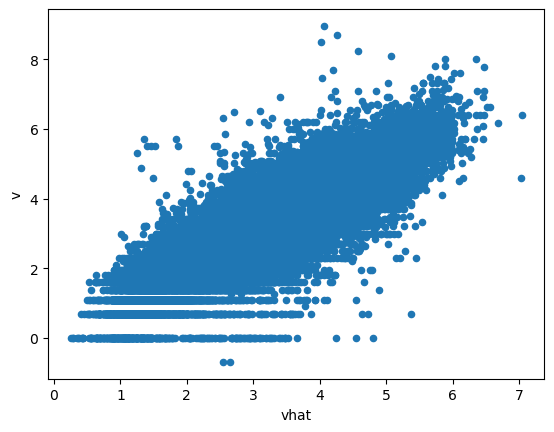

In [13]:
%matplotlib inline
jf = pd.DataFrame({'v':v,'vhat':result1.get_predicted_log_expenditures()})
jf.plot.scatter(x='vhat',y='v')

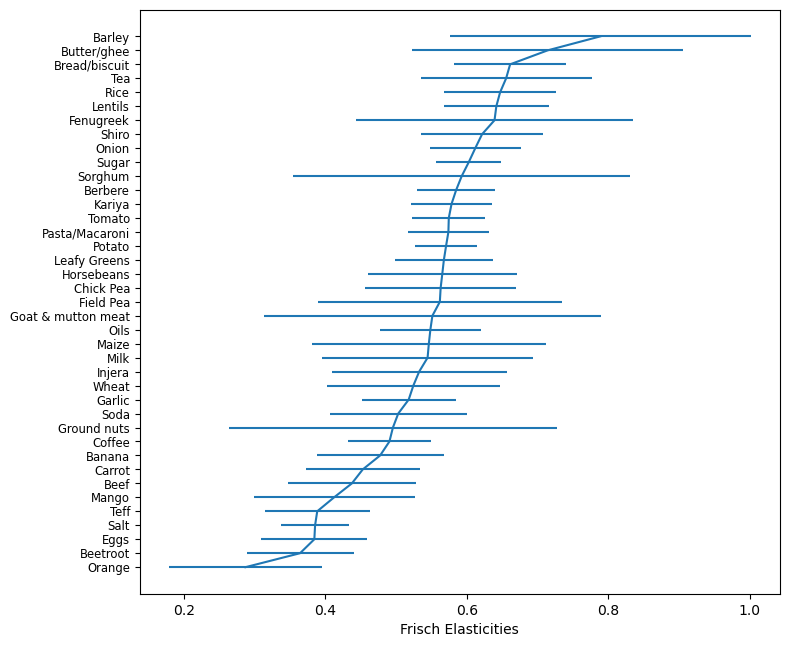

In [14]:
ar = result1.graph_beta()

In [15]:
result1.get_beta()

j
Banana                0.477468
Barley                0.788497
Beef                  0.437551
Beetroot              0.364255
Berbere               0.584863
Bread/biscuit         0.661144
Butter/ghee           0.714137
Carrot                0.452914
Chick Pea             0.562964
Coffee                0.490597
Eggs                  0.384479
Fenugreek             0.639107
Field Pea             0.561824
Garlic                0.517825
Goat & mutton meat    0.551291
Ground nuts           0.495533
Horsebeans            0.565291
Injera                0.532608
Kariya                0.578336
Leafy Greens          0.567523
Lentils               0.641650
Maize                 0.546274
Mango                 0.412395
Milk                  0.544517
Oils                  0.548439
Onion                 0.611916
Orange                0.287136
Pasta/Macaroni        0.573919
Potato                0.570635
Rice                  0.647001
Salt                  0.385525
Shiro                 0.621536
Soda  

In [16]:
result1.get_gamma()

k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize,Constant
j,,,,,,,,,,,,,,,,
Banana,-0.000223,-0.071820,-0.004488,0.008525,0.126822,0.139662,0.137181,0.020005,-0.085434,-0.055332,-0.031909,0.039605,0.221848,-0.048584,0.199641,3.184720
Barley,0.123631,0.015264,0.175775,0.077300,-0.024047,0.050901,0.119388,-0.137367,0.057757,-0.067983,0.086654,0.091864,-0.010543,0.118789,0.315278,3.279068
Beef,-0.077923,-0.166990,-0.061130,0.088782,0.054320,0.078641,0.094031,-0.053129,-0.072109,-0.101158,0.003401,0.014935,0.128632,0.035798,0.327651,5.249297
Beetroot,-0.037668,-0.010173,0.029583,0.049985,0.031633,0.008869,-0.033093,0.025121,0.039359,0.023534,0.103666,0.094776,0.058950,-0.064471,0.107883,2.567754
Berbere,-0.051770,-0.078390,-0.061653,0.010211,0.076010,0.112779,0.024342,-0.016952,-0.041730,-0.068965,-0.053570,0.010489,0.098185,-0.102997,0.202773,3.278178
Bread/biscuit,-0.109215,-0.126816,-0.064790,-0.049173,-0.035787,-0.062688,-0.061074,-0.110885,-0.055362,-0.000541,0.002074,-0.017882,0.083185,-0.067692,0.561302,3.353942
Butter/ghee,-0.034372,-0.027324,-0.008015,-0.071748,-0.001681,-0.016446,-0.062996,0.007327,-0.185239,-0.118303,0.057603,-0.151067,-0.030623,-0.083604,0.378682,4.061405
Carrot,-0.114253,-0.069433,-0.013742,0.116337,0.092286,0.078432,-0.040475,-0.053034,0.055146,-0.027860,0.006346,-0.040555,0.075077,-0.033651,0.198904,2.586219
Chick Pea,-0.066605,0.028546,0.058243,0.008947,-0.029816,-0.035917,0.036748,-0.074359,0.026539,-0.030653,0.067405,0.024487,-0.017291,-0.018822,0.379831,3.167594


<Axes: ylabel='Density'>

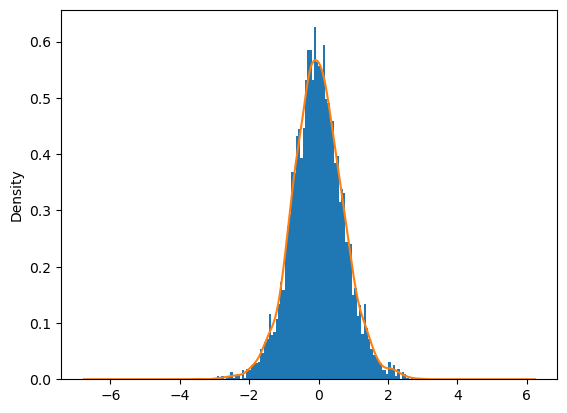

In [18]:
ar = result1.get_w().plot.hist(bins=100,density=True)
result1.get_w().plot.kde(ax=ar)

In [19]:
result1.to_pickle('ethiopia_estimate1516.rgsn')
result1 = cfe.regression.read_pickle('ethiopia_estimate1516.rgsn')

In [20]:
rhat = result1.predicted_expenditures()

# Total food expenditures per household
rbar = rhat.groupby(['i','t','m']).sum()

# Reference budget
rref = rbar.quantile(0.5)  # Household at 0.5 quantile is median

In [21]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean(axis=1)
pbar = pbar[result1.beta.index] # Only use prices for goods we can estimate

# Replace missing prices with 1 (this is because they're best measured in expenditures)
pbar = pbar.replace(np.nan,1)

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,j,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

Text(0.5, 0, 'Quantities of Teff Demanded')

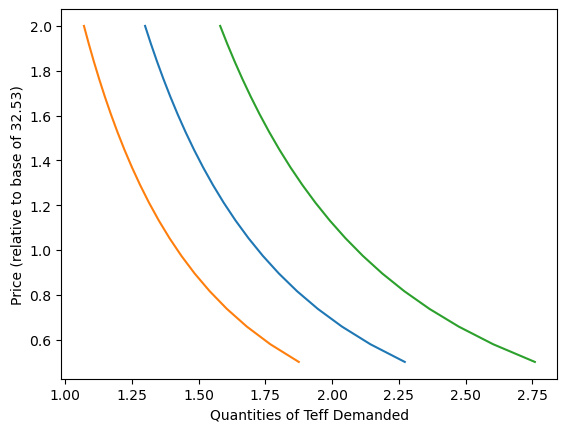

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'Teff'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([result1.demands(rref,my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([result1.demands(rbar.quantile(0.25),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([result1.demands(rbar.quantile(0.75),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

Text(0.5, 1.0, 'Engel Curves')

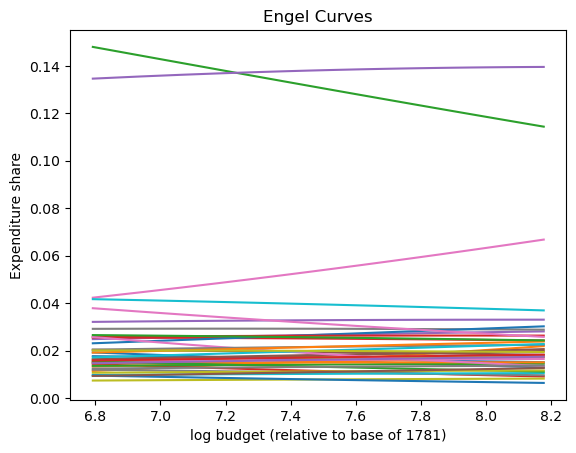

In [23]:
fig,ar = plt.subplots()

ar.plot(np.log(scale*rref),[result1.expenditures(s*rref,pbar)/(s*rref) for s in scale])
ar.set_xlabel(f'log budget (relative to base of {rref:.0f})')
ar.set_ylabel(f'Expenditure share')
ar.set_title('Engel Curves')

Text(0.5, 1.0, 'Indirect Utility Function')

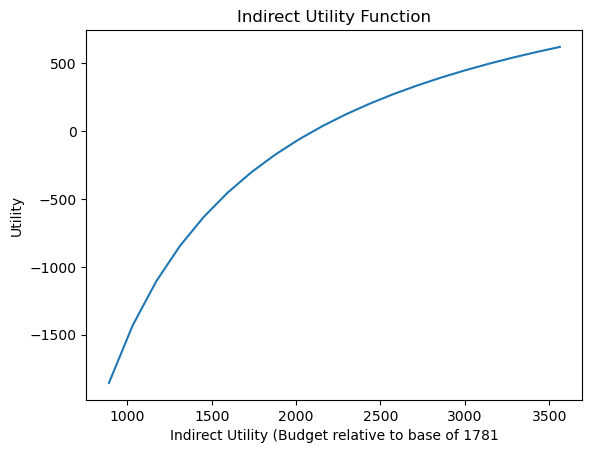

In [24]:
fig,ax = plt.subplots()

ax.plot(scale*rref,[result1.indirect_utility(s*rref,pbar) for s in scale])
ax.set_xlabel(f'Indirect Utility (Budget relative to base of {rref:.0f}')
ax.set_ylabel(f'Utility')
ax.set_title('Indirect Utility Function')

# Nutrient Ratios for Ethopia, 2018-2019

In [25]:
InputFiles = {'Expenditures':('1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E','Food Expenditures (2018-19)'),
              'Prices':('1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E','Food Prices (2018-19)'),
              'HH Characteristics':('1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E','Household Characteristics'),
              'FCT':('1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E','FCT'),
              'RDI':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),}

In [70]:
def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in x.columns:
    x['m'] = 1

## important to keep the type of household id value as str.
x['i'] = x['i'].astype(str)

x = x.set_index(['i','t','m', 'j'])


# x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)

# Get HH characteristics...
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['i','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get prices
q = get_clean_sheet(InputFiles['Prices'][0],
                    sheet=InputFiles['Prices'][1])

if 'm' not in q.columns:  # Supply "market" indicator if missing
    q['m'] = 1

q = q[q['u'] == 'Kg']
q = q.drop(columns = ['u'])
q = q.set_index(['t','m', 'j'])

q = q.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

#### This bit peculiar to Niger FCT #####
#fct = fct.loc[fct.Code.str.len()==6]
#fct = fct.set_index('Code')
#fct.columns = [v.replace('\n',' ') for v in fct.columns]
########################################
fct = fct.rename(columns={'index':'j'})
fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))
fct = fct.replace(np.nan, 0)

################## RDI, if available (consider using US) #####################
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

In [71]:
result2 = cfe.Regression(y=np.log(x['Expenditure']),d=z)
result2.get_beta().sort_values(ascending=False) # Check sanity...

j
Barley                0.788497
Butter/ghee           0.714137
Bread/biscuit         0.661144
Tea                   0.655502
Rice                  0.647001
Lentils               0.641650
Fenugreek             0.639107
Shiro                 0.621536
Onion                 0.611916
Sugar                 0.602717
Sorghum               0.592757
Berbere               0.584863
Kariya                0.578336
Tomato                0.574467
Pasta/Macaroni        0.573919
Potato                0.570635
Leafy Greens          0.567523
Horsebeans            0.565291
Chick Pea             0.562964
Field Pea             0.561824
Goat & mutton meat    0.551291
Oils                  0.548439
Maize                 0.546274
Milk                  0.544517
Injera                0.532608
Wheat                 0.524379
Garlic                0.517825
Soda                  0.503051
Ground nuts           0.495533
Coffee                0.490597
Banana                0.477468
Carrot                0.452914
Beef  

In [72]:
result2.to_pickle('./foo.pickle')

In [73]:
result2 = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...
xhat = result2.predicted_expenditures()
# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/q['Price'].unstack('j')).dropna(how='all')
# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

In [74]:
use = fct.index.intersection(qhat.columns)
nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean() 

n
Energy          85619.701784
Protein          2788.874698
Vitamin A       30657.669391
Vitamin D         164.809077
Vitamin E         233.993878
Vitamin C        2288.261339
Vitamin B-6        80.089942
Vitamin B-12      199.588358
Calcium         28147.902072
Magnesium       20477.762998
Iron              935.701002
Zinc              468.253444
Fiber             544.176977
Folate           1762.482492
Carbohydrate     4190.279451
Niacin            209.776618
Phosphorus      23701.933118
Potassium       29949.356722
Riboflavin         16.551513
Thiamin            24.284273
Vitamin K         135.914670
dtype: float64

In [78]:
z.columns = [
    col.replace('Females', 'F')
       .replace('Males', 'M')
       .replace('51-99', '51+')
    for col in z.columns
]

In [87]:
z

F 00-03  M 00-03  F 04-08  M 04-08  F 09-13  \
i              t       m                                                        
1010101601002  2011-12 Tigray           0        0        0        1        1   
               2013-14 Tigray           1        0        1        1        1   
               2015-16 Tigray           0        0        0        0        0   
1010101601017  2011-12 Tigray           0        0        1        0        1   
               2013-14 Tigray           1        0        1        1        1   
...                                   ...      ...      ...      ...      ...   
15010203102109 2013-14 Dire Dawa        0        0        0        0        0   
               2015-16 Dire Dawa        0        0        1        0        0   
15010203102121 2011-12 Dire Dawa        0        0        0        1        1   
               2013-14 Dire Dawa        0        0        0        1        1   
               2015-16 Dire Dawa        0        0        0        0        1   

                                  M 09-13  F 14-18  M 14-18  F 19-30  M 19-30  \
i              t       m                                                        
1010101601002  2011-12 Tigray           1        0        1        0        0   
               2013-14 Tigray           0        0        1        0        0   
               2015-16 Tigray           0        0        0        0        0   
1010101601017  2011-12 Tigray           2        0        0        0        0   
               2013-14 Tigray           1        0        1        1        0   
...                                   ...      ...      ...      ...      ...   
15010203102109 2013-14 Dire Dawa        0        0        0        0        1   
               2015-16 Dire Dawa        0        0        0        0        0   
15010203102121 2011-12 Dire Dawa        1        0        0        1        0   
               2013-14 Dire Dawa        1        0        0        1        0   
               2015-16 Dire Dawa        1        0        1        0        0   

                                  F 31-50  M 31-50  F 51+  M 51+  
i              t       m                                          
1010101601002  2011-12 Tigray           1        1      1      0  
               2013-14 Tigray           1        1      1      0  
               2015-16 Tigray           0        0      1      0  
1010101601017  2011-12 Tigray           1        1      0      0  
               2013-14 Tigray           0        1      0      0  
...                                   ...      ...    ...    ...  
15010203102109 2013-14 Dire Dawa        0        0      1      0  
               2015-16 Dire Dawa        0        0      1      0  
15010203102121 2011-12 Dire Dawa        1        0      0      0  
               2013-14 Dire Dawa        1        0      0      0  
               2015-16 Dire Dawa        1        0      0      0  

[20896 rows x 14 columns]

In [76]:
z = z[rdi.columns.tolist()]
hh_rdi = z@rdi.T
hh_rwi = hh_rdi*7

In [79]:
# Match up nutrient names
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)
#nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()
nutrient_ratio = (nutrients[use_nutrients] / hh_rwi[use_nutrients].where(hh_rwi[use_nutrients] != 0)).dropna()


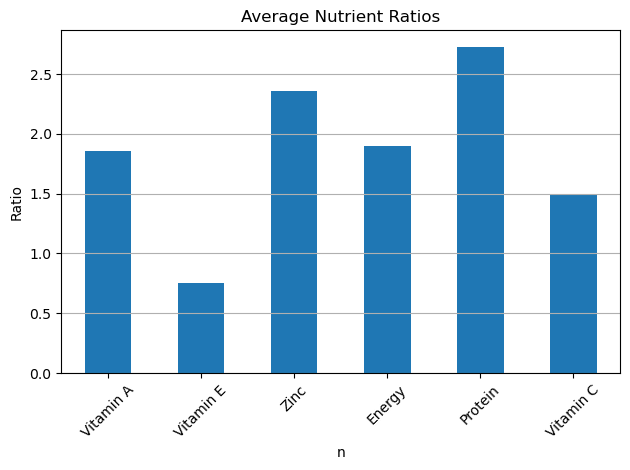

In [80]:
selected_nutrients = ['Vitamin A', 'Vitamin E', 'Zinc', 'Energy', 'Protein', 'Vitamin C']
nutrient_means = nutrient_ratio[selected_nutrients].mean()
nutrient_means.plot(kind='bar')
plt.title('Average Nutrient Ratios')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

<Axes: >

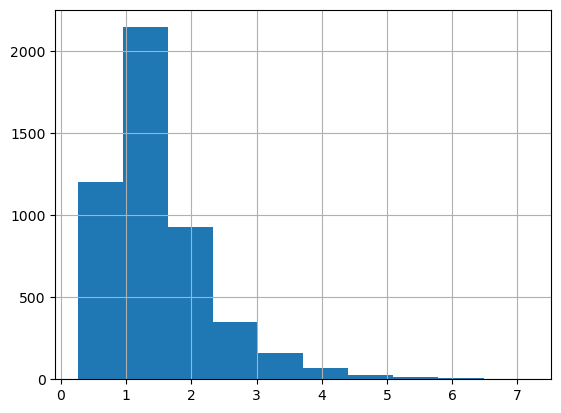

In [86]:
protein_data = nutrient_ratio['Vitamin C']
protein_data.hist()

# Nutrient Demands for Ethopia, 2018-2019

### Introduction



In our last project we used data to estimate systems of food demand
using different datasets.  An output from that project was as set of
`cfe.Regression` objects; these bundle together both data and the results
from the demand system estimation, and can be used for prediction as
well.

Here we&rsquo;ll explore some of the uses of the `cfe.Regression` class, using
an instance created previously (as in Project 3).

After having estimated a demand system using data from our favorite country, we can imagine different counterfactual scenarios.  What if prices were different?  What if we give a cash transfer to a household?  What if school fees reduce the budget for food?  What are the consequences of any of these for diet & nutrition?

If you don&rsquo;t already have the latest version of the `CFEDemands` package
installed, grab it, along with some dependencies:



In [98]:
import pandas as pd
import cfe.regression as rgsn

Using the data on household characteristics and (log) expenditures, we can estimate the demand system (`d`,=y=).  This gives us predictions of expenditures on different kinds of foods.  Then if we divide these expenditures by prices, we get predicted quantities of food.

However, here we&rsquo;re interested in nutritional outcomes, so we need a food conversion table:



In [106]:
fct = read_sheets(Ethiopia,sheet='FCT')

fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

KeyError: "None of ['j'] are in the columns"

We also want to establish when nutrition is *adequate* for households with different compositions.  For this, we want data on recommended dietary intakes:



In [10]:
rdi = read_sheets(Uganda_Data,sheet='RDI')

rdi = rdi.set_index('n')
rdi.columns.name = 'k'

rdi = rdi.apply(lambda x: pd.to_numeric(x,errors='coerce'))

#### Pre-estimated Demand Systems



An instance `r` of `cfe.Regression` can be made persistent with
 `r.to_pickle('my_result.pickle')`, which saves the instance &ldquo;on disk&rdquo;, and can be loaded using `cfe.regression.read_pickle`.  We use  this method below to load data and demand system previously estimated for Uganda:



In [11]:
# Assumes you've already set this up e.g., in Project 3
r = rgsn.read_pickle('../Project3/uganda_estimates.rgsn')

#### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [12]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.loc[r.beta.index].mean(axis=1).fillna(1) # Only use prices for goods we can estimate

#### Budgets



Get food budget for all households, then find median budget:



In [13]:
import numpy as np

xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

#### Food Quantities



Get quantities of food by dividing expenditures by prices:



In [14]:
qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

qhat

,,j,Avocado,Beans (dry),Beans (fresh),Beef,Bogoya,Bread,Cabbage (green),Cassava (dry),Cassava (fresh),Chapati,...,Pumpkins,Restaurant (food),Restaurant (soda),Rice,Salt,Sweet Potatoes (fresh),Tea (leaves),Tomatoes,Waragi,Yams (arrowroot)
i,t,m,,,,,,,,,,,,,,,,,,,,,
0007d1f1449242feb5a25429644fb991,2019-20,Northern,2.209403,1.506613,2.844162,1.503323,2.486181,0.945574,0.820659,7.850213,4.439726,1.672519,...,1.342567,11451.140480,1.314858,1.335827,0.336506,5.848808,0.026302,2.244143,0.761756,0.959463
0010cbae3cea4ec9831f6cd92b02dc16,2019-20,Northern,1.459830,0.778130,1.853234,1.011302,1.280187,0.610725,0.475460,4.330083,2.694336,1.050784,...,0.763565,11727.099141,0.833490,0.832755,0.234808,2.961365,0.022091,1.682104,0.569435,0.413925
00246782f8654441a9df0f6ec0b6fc9f,2019-20,Northern,1.071343,0.543490,1.547024,0.604423,0.654072,0.462187,0.381301,4.987147,2.539555,0.851398,...,0.428032,12092.405538,0.486021,0.643421,0.240394,2.719655,0.015237,1.236337,0.248856,0.243092
005fbc5779014a0290b088071bde9f72,2019-20,Central,1.981667,0.495003,1.881436,1.181063,1.190950,0.899238,0.431796,1.245784,2.641604,1.351628,...,0.567533,17228.253594,1.302327,0.891188,0.130937,3.322815,0.021731,1.695908,0.444169,0.547456
009c1baa0edb44f8af47773ce0b7caaa,2019-20,Western,2.145477,0.866052,3.952756,0.938625,1.697148,0.706824,0.477645,2.235580,2.364876,1.345827,...,0.365992,18633.478835,0.998218,0.737599,0.252386,2.204310,0.026549,2.214209,0.537086,0.555704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff77648719664071a4e363956db92c08,2019-20,Eastern,1.396771,0.393958,1.550997,0.782359,0.726083,0.619387,0.377759,2.817438,2.169230,0.922132,...,0.444980,9581.013920,0.853458,0.963667,0.133548,4.218403,0.015164,1.356558,0.445513,0.693028
ff8b330984bc466aaf2366c3eea3d8cc,2019-20,Northern,2.683808,1.768895,6.299459,1.601310,1.895769,1.195281,1.008878,13.520523,8.743153,2.312154,...,1.388860,9442.891705,1.259462,2.746442,0.430892,17.548848,0.038561,2.353951,0.191041,1.362888
ffb33b3ededa4019a02be24224ab0440,2019-20,Western,3.145855,2.077181,4.544988,1.803418,3.118036,1.333742,0.813193,5.646849,4.618156,1.922582,...,0.680042,14475.522289,1.468559,1.662608,0.406664,4.633661,0.044573,2.925805,0.939723,1.130261


Finally, define a function to change a single price in the vector $p$:



In [15]:
def my_prices(j,p0,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed at p.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

### Demands



#### Demand functions



In [16]:
%matplotlib inline

Text(0.5, 0, 'Quantities of Matoke Demanded')

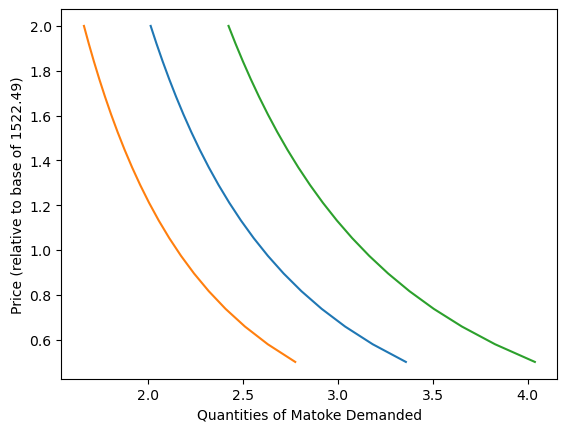

In [17]:
import matplotlib.pyplot as plt

use = 'Matoke'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Matoke for household at median budget
plt.plot([r.demands(xref,my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Matoke for household at 25% percentile
plt.plot([r.demands(xbar.quantile(0.25),my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Matoke for household at 75% percentile
plt.plot([r.demands(xbar.quantile(0.75),my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

#### Engel Curves



/srv/conda/lib/python3.11/site-packages/consumerdemands/root_with_precision.py:83: UserWarning: Tolerance is set to 1.00E-12.  Change in value is -3.64E-12.  Iterations are 1001.  Perhaps tolerance is too high?
  warn("Tolerance is set to %.2E.  Change in value is %.2E.  Iterations are %d.  Perhaps tolerance is too high?" % (tol,x[0]-x[-1],i))


Text(0.5, 1.0, 'Engel Curves')

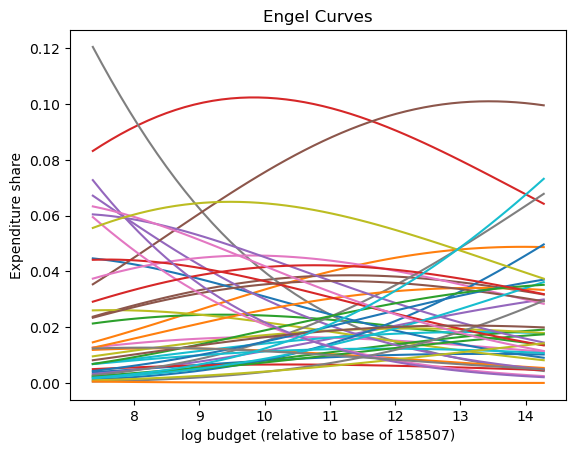

In [18]:
fig,ax = plt.subplots()

scale = np.geomspace(.01,10,50)

ax.plot(np.log(scale*xref),[r.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

### Mapping to Nutrients



We&rsquo;ve seen how to map prices and budgets into vectors of consumption
 quantities using `cfe.Regression.demands`.  Next we want to think about
 how to map these into bundles of *nutrients*.  The information needed
 for the mapping comes from a &ldquo;Food Conversion Table&rdquo; (or database,
 such as the [USDA Food Data Central](https://fdc.nal.usda.gov/)).    We&rsquo;ve already grabbed an FCT, let&rsquo;s take a look:



In [19]:
fct

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc,Magnesium,Phosphorus,Potassium,Vitamin E,Vitamin K
j,,,,,,,,,,,,,,,,,,,,
Apples,617.893,1.875,20.43,0,46.56,147.817,0.0,0.90,0.6625,0.0875,0,0.0,0.2131,0,0.1964,46.95,91.83,953.1,0.0,0
Avocado,1600.000,20.000,70.00,810,120.00,85.000,6.0,17.38,1.3000,0.6700,70,0.0,2.5700,100,6.0000,0.00,0.00,0.0,0.0,0
Beans (dry),1700.000,98.000,60.00,500,580.00,325.000,30.0,7.00,1.2000,3.4000,0,0.0,2.1500,10,8.0000,0.00,0.00,0.0,0.0,0
Beans (fresh),3470.000,214.000,160.00,5250,1130.00,626.000,51.0,11.74,2.1200,7.1300,0,0.0,4.7400,63,23.0000,0.00,0.00,0.0,0.0,0
Beef,2510.000,182.000,0.00,60,70.00,0.000,19.0,31.50,1.6000,0.9000,0,28.9,3.8000,0,37.0000,0.00,0.00,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Water,0.000,0.000,0.00,0,30.00,0.000,0.0,0.00,0.0000,0.0000,0,0.0,0.0000,0,0.1000,10.00,0.00,0.0,0.0,0
Watermelon,300.000,6.100,4.00,30,70.00,75.500,2.4,1.78,0.2100,0.3300,280,0.0,0.4500,81,1.0000,0.00,0.00,0.0,0.0,0
Wheat (flour),3640.000,103.000,30.00,260,150.00,763.000,12.0,12.50,0.4000,1.2000,0,0.0,0.4400,0,7.0000,0.00,0.00,0.0,0.0,0


We need the index of the Food Conversion Table (FCT) to match up with
 the index of the vector of quantities demanded.   To manage this we
 make use of the `align` method for `pd.DataFrames`:



In [20]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index(['Avocado', 'Beans (dry)', 'Beans (fresh)', 'Beef', 'Bogoya', 'Bread',
       'Cabbage (green)', 'Cassava (dry)', 'Cassava (fresh)', 'Chapati',
       'Cooking Oil (refined)', 'Dodo', 'Donuts', 'Eggplant', 'Eggs',
       'Goat Meat', 'Ground Nuts (pounded)', 'Ground Nuts (shelled)',
       'Irish Potatoes', 'Jam/Marmalade', 'Maize (cobs)', 'Maize (flour)',
       'Mangos', 'Matoke', 'Millet Flour', 'Mukene', 'Onions', 'Oranges',
       'Pumpkins', 'Rice', 'Salt', 'Restaurant (soda)',
       'Sweet Potatoes (fresh)', 'Tea (leaves)', 'Tomatoes', 'Waragi',
       'Yams (arrowroot)'],
      dtype='object', name='j')


Now, since rows of `fct0` and `c0` match, we can obtain nutritional
 outcomes from the inner (or dot, or matrix) product of the transposed
 `fct0` and `c0`:



In [21]:
# The @ operator means matrix multiply
N = fct0.T@c0

N  #NB: Uganda quantities are for previous 7 days

i,0007d1f1449242feb5a25429644fb991,0010cbae3cea4ec9831f6cd92b02dc16,00246782f8654441a9df0f6ec0b6fc9f,005fbc5779014a0290b088071bde9f72,009c1baa0edb44f8af47773ce0b7caaa,00b48fb6bcf84dd581bd7b2be5f908a0,00c2b27287a74f948fef24a8de42825c,00cb487f12014891b3efa5c8679d18ab,00d5da8bbd544c548a71f176496ee4b6,00dc3a212a1f40698656b2dc7cc97a85,...,fef6a31f5c8542aead247c12573e0307,ff3346434ae6489fa2dc81e9df5a84db,ff5869d3420643fbbdb7897ea89d009f,ff62baaeffbf44029f0e689447dafca9,ff6c8b1a47334dc88d74ee0f5e2d880c,ff77648719664071a4e363956db92c08,ff8b330984bc466aaf2366c3eea3d8cc,ffb33b3ededa4019a02be24224ab0440,ffea6d0233164dd3afe28545f2cbb5f9,ffec87c6ae87498f956723afe69266b9
t,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,...,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20
m,Northern,Northern,Northern,Central,Western,Central,Central,Northern,Northern,Eastern,...,Western,Central,Northern,Northern,Eastern,Eastern,Northern,Western,Central,Eastern
n,,,,,,,,,,,,,,,,,,,,,
Energy,199065.428660,115400.289742,98233.194565,116095.454583,124673.117935,124270.816912,138623.056593,73713.191397,236745.138011,159605.121342,...,165750.013254,178125.147981,307413.672423,172376.267277,125045.668992,103307.811203,313105.949511,216275.578171,86445.571046,154299.067585
Protein,3933.420432,2308.031983,1698.978072,2321.086910,2758.489225,2481.925174,2972.475172,1434.071144,4483.769569,2719.026225,...,3363.094065,3701.905480,6104.634583,3203.690664,2198.445447,1893.787233,6050.323803,4794.551015,1667.027491,2795.608815
Fiber,2933.992009,1619.791444,1288.941709,1617.342531,2000.390486,1732.766533,2214.901211,999.395217,3321.920302,2270.857056,...,2412.607765,2609.708695,4777.461396,2382.165810,1700.087776,1431.279045,4923.021179,3449.748416,1129.248139,2169.429787
Folate,39550.301396,24179.851897,19352.432318,25541.776036,36788.567844,27250.738629,38327.932099,15067.558176,49562.800641,30699.938051,...,41236.427617,42709.112802,69976.780458,33318.511744,24161.939390,20889.953777,69021.445208,53234.210931,18502.001024,29966.453122
Calcium,24573.161426,15031.718456,11875.391686,16886.419612,18384.759989,18016.673911,20550.357310,9559.183976,28750.111195,21041.027958,...,22191.872478,25450.998776,38272.295474,20493.792164,16142.849236,14029.807487,42233.691704,30133.379210,12186.028417,20125.734425
Carbohydrate,28006.694167,15172.960232,13045.641862,13973.618284,15511.607492,14957.355957,18396.664008,9928.901273,30626.311492,23120.098531,...,19896.808707,21940.390063,42202.537744,22764.605897,16856.955434,13586.829840,48586.473062,30070.379887,9904.986396,20567.263290
Iron,1032.343149,593.114796,475.980638,577.918623,684.632586,618.041856,753.200153,378.362907,1176.510546,770.869753,...,835.511238,915.948672,1624.011894,851.091394,592.753117,495.148018,1680.185029,1193.164772,415.280591,731.422726


Of course, since we can compute the nutritional content of a vector of
 consumption goods `c0`, we can also use our demand functions to
 compute nutrition as a *function* of prices and budget.



In [22]:
def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices:



Text(0, 0.5, 'log nutrient')

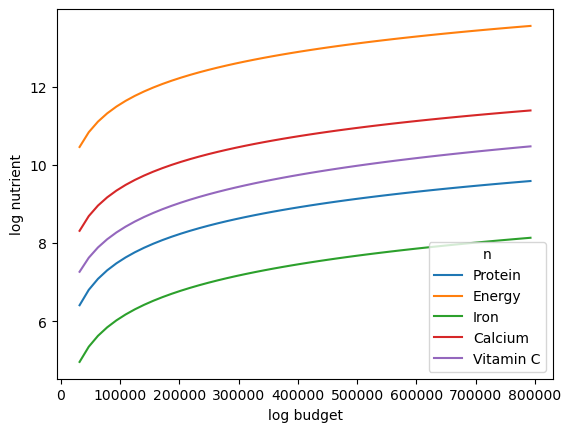

In [23]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(xref/5,xref*5,50)

UseNutrients = ['Protein','Energy','Iron','Calcium','Vitamin C']

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

Now how does nutrition vary with prices?



Text(0, 0.5, 'log nutrient')

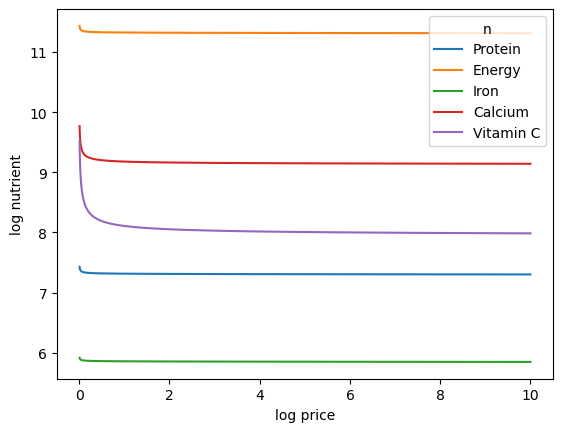

In [24]:
USE_GOOD = 'Oranges'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(USE_GOOD,pbar[USE_GOOD]*s)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For the average household in our data, the number of
different kinds of people can be computed by averaging over households:



In [25]:
# In first round, averaged over households and villages
dbar = r.d[rdi.columns].mean()

Now, the inner/dot/matrix product between `dbar` and the `rdi`
DataFrame of requirements will give us minimum requirements for the
average household:

